# Count Regression with Variable Exposure

In [4]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import nbinom

In [5]:
az.style.use("arviz-darkgrid")
SEED = 7355608

This example is based on the [“Roaches”](https://github.com/avehtari/ROS-Examples/tree/master/Roaches/) example from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/) by Gelman, Hill, and Vehtari. The example is a count regression model with an offset term.

The data is the number of roaches caught in 262 apartments. Some pest control treatment was applied to 158 (treatment=1) of the apartments, and 104 apartments received no treatment (treatment=0). The other columns in the data are:

* ```y```: the number of roaches caught
* ```roach1``` : the pre-treatment roach level
* ```senior``` : indicator for whether the appartment is for seniors
* ```exposure2``` : the number of trap-days (number of traps x number of days).

In [6]:
roaches = pd.read_csv("data/roaches.csv", index_col=0)
# rescale 
roaches["roach1"] = roaches["roach1"] / 100
roaches.head()

,y,roach1,treatment,senior,exposure2
1,153,3.0800,1,0,0.800000
2,127,3.3125,1,0,0.600000
3,7,0.0167,1,0,1.000000
4,7,0.0300,1,0,1.000000
5,0,0.0200,1,0,1.142857


## Poisson regression

One way to model this is to say that there is some rate of roaches per trap-day , and that the number of roaches caught is a Poisson random variable with a rate that is proportional to the number of trap-days (the exposure). That is:

$$
\begin{align}
y_i &\sim \textrm{Poisson}( \textrm{exposure2} \times \rho ) \\
\textrm{log}(\rho_i) &= \beta_0 + \beta_1 \textrm{treatment}_i
+ \beta_2 \textrm{roach1}_i + \beta_3 \textrm{senior}_i
\end{align}
$$

With a little algebra, we can rewrite this as a generalized linear model:

$$
\begin{align}
y_i &\sim \textrm{Poisson}( \lambda_i ) \\
\textrm{log}(\lambda_i) &= \beta_0 + \beta_1 \textrm{treatment}_i
+ \beta_2 \textrm{roach1}_i + \beta_3 \textrm{senior}_i
+ \textrm{log}(\textrm{exposure2}_i)
\end{align}
$$

However, we don’t want to estimate a coefficient for $\textrm{log}(\textrm{exposure2})$
, we want to simply add it as an offset. In bambi we do this by using the offset function in the formula to specify that a term should not be multiplied by a coefficient to estimate and simply added. The formula for the model is then:

```"y ~ roach1 + treatment + senior + offset(log(exposure2))"```

If you are familiar with R this offset term is the same as the offset term in the glm function.

In [7]:
# bambi poisson model
model_1 = bmb.Model("y ~ roach1 + treatment  + senior + offset(log(exposure2))", family = "poisson", data = roaches)
idata_1 = model_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, roach1, treatment, senior]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [8]:
az.summary(idata_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.089,0.021,3.049,3.127,0.000,0.0,4158.0,3677.0,1.0
roach1,0.698,0.009,0.681,0.714,0.000,0.0,3176.0,2862.0,1.0
senior,-0.380,0.033,-0.438,-0.313,0.001,0.0,3962.0,3112.0,1.0
treatment,-0.516,0.025,-0.565,-0.473,0.000,0.0,4720.0,3459.0,1.0


The sampling seems to have gone well based on ```ess``` and ```r_hat```. If this were a real analysis one would also need to check priors, trace plots and other diagnostics. However, lets see if the model predicts the distribution of roaches (```y```) observed. We can do this by looking at the posterior predictive distribution for the model. We plot the log of ```y``` to make the results easier to see.

In [9]:
def plot_log_posterior_ppc(model, idata):
    # plot posterior predictive check
    model.predict(idata, kind='response', inplace=True)
    var_name = 'log(y+1)'
    # there is probably a better way
    idata.posterior_predictive[var_name] = np.log(idata.posterior_predictive['y'] + 1)
    idata.observed_data[var_name] = np.log(idata.observed_data['y'] + 1)
    
    return az.plot_ppc(idata, var_names=[var_name])

<Axes: xlabel='log(y+1)'>

c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


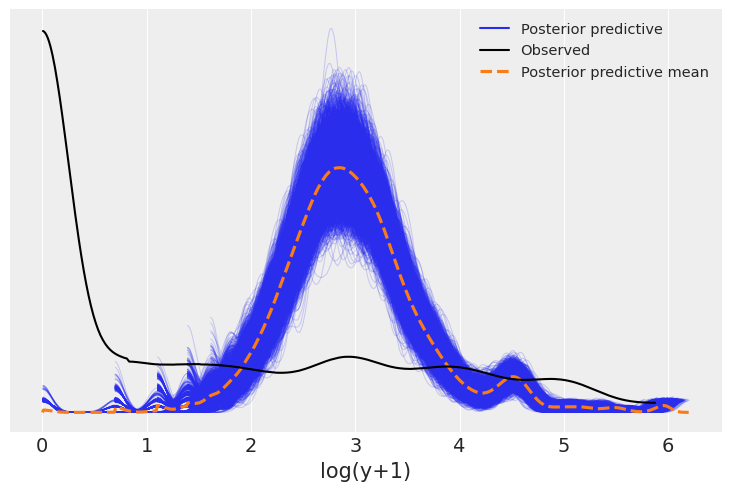

In [10]:
plot_log_posterior_ppc(model_1, idata_1)

It appears that we are drastically under predicting the number of apartments with a small number of roaches. This suggests creating a test statistic measuring the fraction of zeros, both in the observed data and in the simulated replications (posterior predictions). We can then use this to check the model fit.

In [11]:
# check number of zeros in y

def check_zeros(idata):
    # flatten over chains:
    sampled_zeros = (idata.posterior_predictive["y"]==0).mean(("__obs__")).values.flatten()
    print(f"Fraction of zeros in the observed data: {np.mean(roaches['y']==0)}")
    print(f"Fraction of zeros in the posterior predictive check: {np.mean(sampled_zeros)}")
    print(f" 80% CI: {np.percentile(sampled_zeros, [10, 90])}")

check_zeros(idata_1)
 

Fraction of zeros in the observed data: 0.35877862595419846
Fraction of zeros in the posterior predictive check: 0.000748091603053435
 80% CI: [0.         0.00381679]


The Poisson model here does not succeed in reproducing the observed fraction of zeros. In the data we have about 36% zeros, while in the replications we almost always have no zeros or very few. Gelman, Hill, and Vehtari suggest we try an overdispersed and more flexible model like the negative binomial.

## Negative Binomial Fit

In [12]:
# bambi poisson model
model_2 = bmb.Model("y ~ roach1 + treatment  + senior + offset(log(exposure2))", family = "negativebinomial", data = roaches)
idata_2 = model_2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, roach1, treatment, senior]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


In [13]:
az.summary(idata_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.855,0.237,2.425,3.311,0.003,0.002,5727.0,3601.0,1.0
alpha,0.272,0.026,0.225,0.322,0.000,0.000,5442.0,3375.0,1.0
roach1,1.314,0.248,0.842,1.775,0.004,0.003,4997.0,3164.0,1.0
senior,-0.332,0.264,-0.793,0.174,0.004,0.003,4726.0,3161.0,1.0
treatment,-0.784,0.250,-1.245,-0.312,0.003,0.003,5313.0,3289.0,1.0


<Axes: xlabel='log(y+1)'>

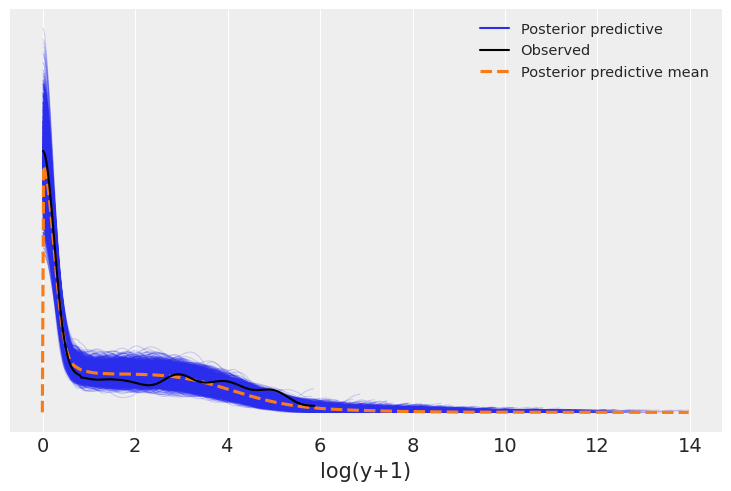

In [14]:
plot_log_posterior_ppc(model_2, idata_2)

In [15]:
check_zeros(idata_2)

Fraction of zeros in the observed data: 0.35877862595419846
Fraction of zeros in the posterior predictive check: 0.3378473282442748
 80% CI: [0.28625954 0.38931298]


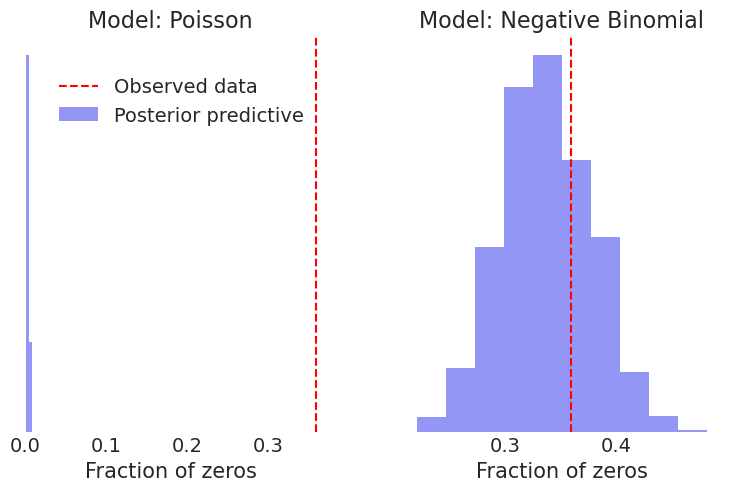

In [16]:
def plot_zeros(ax, idata, model_label, **kwargs):
    data_zeros = np.mean(roaches['y']==0)
    # flatten over chains:
    sampled_zeros = (idata.posterior_predictive["y"]==0).mean(("__obs__")).values.flatten()
    ax.hist(sampled_zeros, alpha=0.5, **kwargs)
    ax.axvline(data_zeros, color='red', linestyle='--')
    ax.set_xlabel("Fraction of zeros")
    ax.set_title(f"Model: {model_label}")
    ax.yaxis.set_visible(False)
    ax.set_facecolor('white')
    return ax

fig, ax = plt.subplots(1,2, gridspec_kw={'wspace': 0.2})
plot_zeros(ax[0],idata_1, "Poisson", bins= 2) # use 2 bins to make it more clear. Almost no zeros.
plot_zeros(ax[1],idata_2, "Negative Binomial")

fig.legend(["Observed data", "Posterior predictive"], loc='center left', bbox_to_anchor=(0.05, 0.8)) 

The negative binomial distribution fit works much better, predicting the number of zeros consistent with the observed data.

Regression and Other Stories introduces a further improvement by introducing a zero-inflated regression later in the chapter, but I will not persue that here, after all the point of this example is to illustrate the use of offsets.

## PYMC equivalent model

The model behind the scenes looks like this for the Poission model.

In [17]:
pymc_model = model_1.backend
pymc_model.model

Intercept ~ Normal(0, 4.52)
   roach1 ~ Normal(0, 3.33)
treatment ~ Normal(0, 5.11)
   senior ~ Normal(0, 5.43)
       mu ~ Deterministic(f(senior, treatment, roach1, Intercept))
        y ~ Poisson(mu)

Let’s look at the equivalent (Poisson) model in PYMC:

In [18]:
# recreate the model using pymc
import pymc as pm
with pm.Model() as model_pymc:
    # priors
    alpha = pm.Normal("Intercept", mu=0, sigma=4.5)
    beta_roach1 = pm.Normal("beta_roach1", mu=0, sigma=3.3)
    beta_treatment = pm.Normal("beta_treatment", mu=0, sigma=5.11)
    beta_senior = pm.Normal("beta_senior", mu=0, sigma=5.43)
    
    # likelihood
    mu = pm.math.exp(alpha + beta_roach1 * roaches["roach1"] +
                             beta_treatment * roaches["treatment"] +
                             beta_senior * roaches["senior"] +
                             pm.math.log(roaches["exposure2"])) # no beta for exposure2 
    y = pm.Poisson("y", mu=mu, observed=roaches["y"])

    idata_pymc = pm.sample(1000)  

az.summary(idata_pymc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta_roach1, beta_treatment, beta_senior]


c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.089,0.021,3.049,3.127,0.000,0.0,3101.0,2855.0,1.0
beta_roach1,0.698,0.009,0.682,0.715,0.000,0.0,2960.0,2689.0,1.0
beta_senior,-0.380,0.034,-0.441,-0.313,0.001,0.0,3561.0,2897.0,1.0
beta_treatment,-0.517,0.025,-0.565,-0.472,0.000,0.0,3381.0,2643.0,1.0


In this model (```model_pymc```) we have the equivalent Poisson regression with everything explicit to illustrate what the ‘offset’ function is doing. It simply makes it possible to express a term like this in the ```formulae``` string in a ```bambi``` model.

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Oct 27 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.26.0

matplotlib: 3.9.1
arviz     : 0.19.0
pandas    : 2.2.2
numpy     : 1.26.4
bambi     : 0.14.0
pymc      : 5.16.2

Watermark: 2.4.3

